In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from final_project import loader, builder, models, plots
from final_project.models import ModelENUM
from pathlib import Path
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df = loader.get_df(all_files=True)
df = df[df['Origin'] == 'BOS']
df = df[[
    'DistanceGroup',
    'DayofMonth',
    'Month',
    'Year',
    'Duplicate',
    'ArrDel15',
    'DistanceGroup',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'Operating_Airline',
    'Dest'
]]
df = builder.encodeFrame(df)

delay_df = df[df['ArrDel15'] > 0.5].sample(n=2000)
on_time_df = df[df['ArrDel15'] <= 0.5].sample(n=8000)
sample_df = pd.concat([delay_df, on_time_df], ignore_index=True)


x = sample_df.drop(columns=['ArrDel15'])
y = sample_df[['ArrDel15']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=150)

In [11]:
lr_pipeline = models.get_pipeline(ModelENUM.LR)
param_grid = [
    models.get_lr_param(solver="liblinear", penalty=["l1", "l2"], c_list=[1e-2, 1e-1, 1e1, 1e2], max_iter=[1000]),
    models.get_lr_param(solver="saga", penalty=["l2", "elasticnet"], c_list=[1e-2, 1e-1, 1e1, 1e2], max_iter=[1000]),
    # models.get_lr_param(penalty=["l1", "l2"], c_list=[.1, 1], max_iter=[500]),
 #    # models.get_lr_param(solver="saga", penalty=["l2"], c_list=[.1]),
]
grid_search = models.get_grid_search_cv(
    pipeline=lr_pipeline, param_grid=param_grid, cv=3, n_jobs=20
)

AttributeError: module 'final_project.models' has no attribute 'log_reg'

In [6]:
logreg_model = grid_search.fit(x_train, y_train.to_numpy().ravel())

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 2/3; 1/4] START lr__C=0.1, lr__max_iter=500, lr__penalty=l1, lr__solver=liblinear
[CV 1/3; 2/4] START lr__C=0.1, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear
[CV 3/3; 2/4] START lr__C=0.1, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear
[CV 1/3; 2/4] END lr__C=0.1, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear;, score=0.758 total time=   0.0s
[CV 3/3; 1/4] START lr__C=0.1, lr__max_iter=500, lr__penalty=l1, lr__solver=liblinear
[CV 3/3; 2/4] END lr__C=0.1, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear;, score=0.734 total time=   0.0s
[CV 3/3; 3/4] START lr__C=1, lr__max_iter=500, lr__penalty=l1, lr__solver=liblinear
[CV 2/3; 4/4] START lr__C=1, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear
[CV 2/3; 4/4] END lr__C=1, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear;, score=0.767 total time=   0.0s
[CV 1/3; 3/4] START lr__C=1, lr__max_iter=500, lr__penalty=l1, lr__solver=libli

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 1/4] END lr__C=0.1, lr__max_iter=500, lr__penalty=l1, lr__solver=liblinear;, score=0.728 total time=   0.9s
[CV 2/3; 1/4] END lr__C=0.1, lr__max_iter=500, lr__penalty=l1, lr__solver=liblinear;, score=0.751 total time=   1.1s


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 1/4] END lr__C=0.1, lr__max_iter=500, lr__penalty=l1, lr__solver=liblinear;, score=0.751 total time=   1.1s


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 3/4] END lr__C=1, lr__max_iter=500, lr__penalty=l1, lr__solver=liblinear;, score=0.752 total time=   1.4s
[CV 3/3; 3/4] END lr__C=1, lr__max_iter=500, lr__penalty=l1, lr__solver=liblinear;, score=0.728 total time=   1.8s
[CV 1/3; 3/4] END lr__C=1, lr__max_iter=500, lr__penalty=l1, lr__solver=liblinear;, score=0.751 total time=   1.7s


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [7]:
params = models.get_best_params(ModelENUM.LR, logreg_model)
print(params)
# models.save_model(ModelENUM.LR, logreg_model)

{'solver': 'liblinear', 'penalty': 'l2', 'C': 1}


In [9]:
models.analyze_model(logreg_model, x_test, x_train, y_test, y_train)

Test accuracy: 0.7586206896551725
Train accuracy: 0.7609375
Precision: 1.0
Recall: 0.6111111111111112
F-Beta Score: 0.7586206896551725
F1 Score: 0.7586206896551725


414


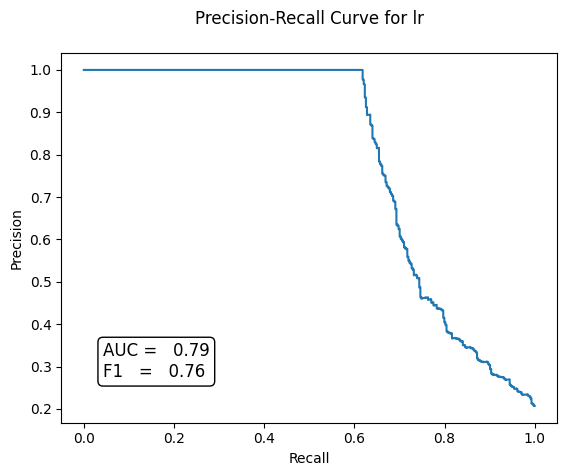

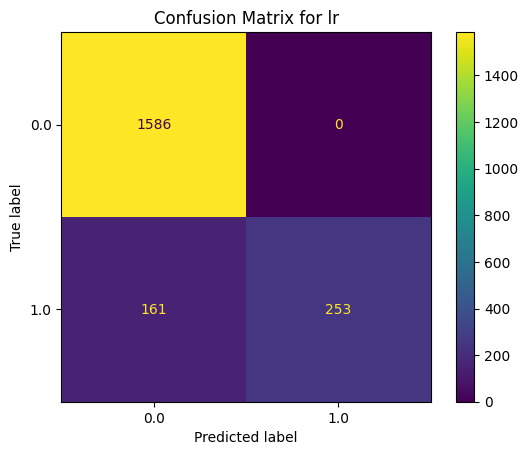

In [10]:
import numpy as np
number_true = np.count_nonzero(y_test == 1)
print(number_true)

y_prob = logreg_model.predict_proba(x_test)[:, 1]
y_pred = logreg_model.predict(x_test)
plots.save_precision_recall_curve("lr", "test_file", y_test, y_prob)
plots.save_confusion_matrix("lr", "test_file", y_test, y_pred)